In [1]:
!pip install -q skorch cleanlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 16.1 MB/s eta 0:00:00


In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import (
    nn,
    optim
)

import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import (
    Compose,
    ToTensor,
    RandomHorizontalFlip,
)

from skorch import NeuralNet

from cleanlab.filter import find_label_issues

In [7]:
train_transform = Compose([
    RandomHorizontalFlip(
        p=0.5
    ),
    ToTensor()
])

test_transform = Compose([
    ToTensor()
])

train_dataset = CIFAR10(
    root=".",
    train=False,
    transform=test_transform,
    download=True
)

test_dataset = CIFAR10(
    root=".",
    train=False,
    transform=test_transform,
    download=True
)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
label_list = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

def label_id_to_text(
    label_id,
    label_list = label_list
):
    return label_list[label_id]

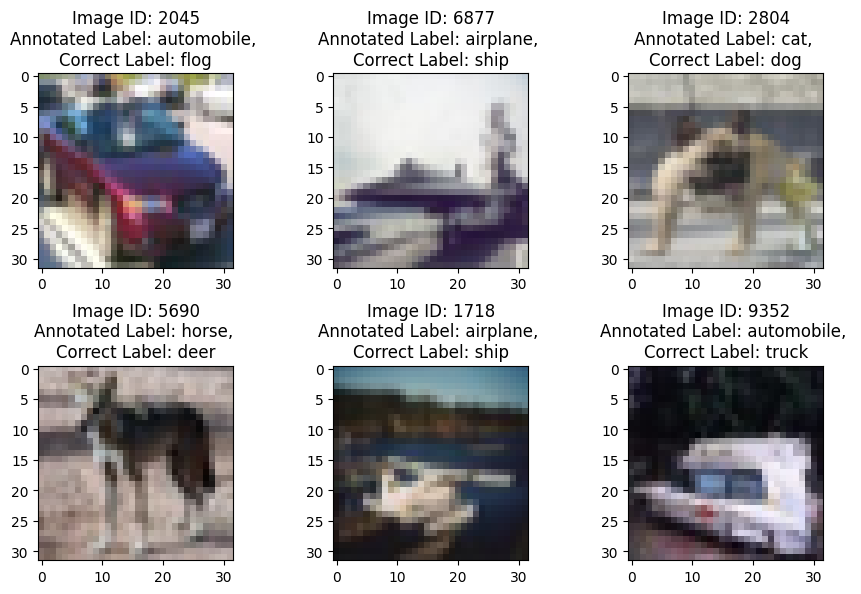

In [12]:
def show_misannotated_image():
    misannotated_img_ids_and_correct_labels = [
        (2045, "flog"),
        (6877, "ship"),
        (2804, "dog"),
        (5690, "deer"),
        (1718, "ship"),
        (9352, "truck")
    ]

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9,6))
    axes = axes.flatten()
    for i in range(len(misannotated_img_ids_and_correct_labels)):
        ax = axes[i]
        img_id, correct_label = misannotated_img_ids_and_correct_labels[i]
        img, label_id = test_dataset[img_id]
        annotated_label = label_id_to_text(label_id)
        img_np = img.numpy()
        ax.set_title(f"Image ID: {img_id}\nAnnotated Label: {annotated_label}, \nCorrect Label: {correct_label}")
        ax.imshow(img_np.transpose(1,2,0))
    plt.tight_layout()

show_misannotated_image()

In [13]:
# 事前学習済みモデル（ResNet）
resnet_pretrained = torchvision.models.resnet18(weights="IMAGENET1K_V1")

for param in resnet_pretrained.parameters():
    param.requests_grad = False

resnet_pretrained.fc = nn.Sequential(
    nn.LazyLinear(out_features=256),
    nn.ReLU(),
    nn.LazyLinear(out_features=10),
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 152MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [14]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = NeuralNet(
    module=resnet_pretrained,
    criterion=nn.CrossEntropyLoss(),
    optimizer=optim.Adam,
    batch_size=128,
    max_epochs=10,
    device=device
)

In [15]:
def torch_fix_seed(
    seed=42
):
    random.seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [16]:
torch_fix_seed()
model.fit(train_dataset)

  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        2.5367        2.2831  134.2135
      2        2.1244        3.2217  137.7770
      3        1.9553        2.1081  128.4093
      4        1.9221        2.0391  152.3793
      5        1.8974        1.9102  135.9718
      6        1.8786        2.1579  144.8231
      7        1.9045        1.9053  114.8484
      8        1.8393        1.9387  121.1153
      9        1.8308        1.8252  116.8314
     10        1.7950        1.7828  113.8590


<class 'skorch.net.NeuralNet'>[initialized](
  module_=ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, mom

In [17]:
test_pred_probs = model.predict_proba(test_dataset)
test_labels = test_dataset.targets

ranked_label_issues = find_label_issues(
    test_labels,
    test_pred_probs,
    return_indices_ranked_by="self_confidence",
)

print(f"アノテーション間違いの疑いがあるのは {len(ranked_label_issues)} 件です")
print(f"間違いの可能性が高い上位１５件のインデックス：\n {ranked_label_issues[:15]}")

アノテーション間違いの疑いがあるのは 5610 件です
間違いの可能性が高い上位１５件のインデックス：
 [ 211 9902 5088  367 3240 1823 6369 5098 9812 7780  417 2440 2000 6859
 1835]


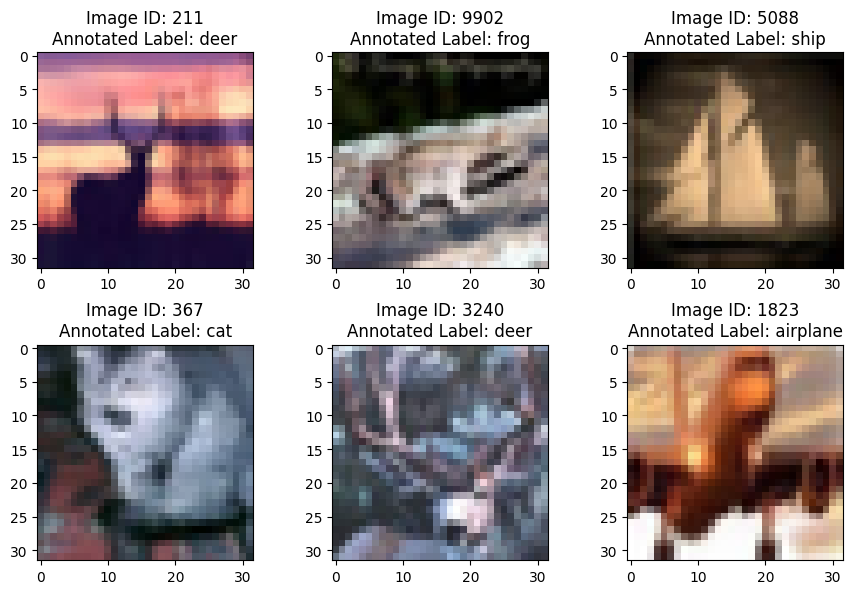

In [19]:
def show_issued_image(
    ranked_label_issues_top6
):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
    axes = axes.flatten()
    for i in range(len(ranked_label_issues_top6)):
        ax = axes[i]
        img_id = ranked_label_issues_top6[i]
        img, label_id = test_dataset[img_id]
        annotated_label = label_id_to_text(label_id)
        img_np = img.numpy()
        ax.set_title(f"Image ID: {img_id}\nAnnotated Label: {annotated_label}")
        ax.imshow(img_np.transpose(1, 2, 0))
    plt.tight_layout()

show_issued_image(ranked_label_issues[:6])